In [1]:
from pathlib import Path
#import warnings
import scanpy as sc
import scib 
import numpy as np
import pandas as pd
import sys 

import scgpt as scg
import matplotlib.pyplot as plt

plt.style.context('default')
#warnings.simplefilter('ignore', ResourceWarning)




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\annel\anaconda3\envs\scgpt_py39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\annel\anaconda3\envs\scgpt_py39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instan

In [3]:
# Check if HVG AnnData file exists in save directory
hvg_file = Path("C:/Users/annel/OneDrive/Documenten/Machine Learning/scGPT/save/adata_hvg.h5ad")

if hvg_file.exists():
    print(f"Loading existing HVG AnnData file from {hvg_file}")
    adata = sc.read_h5ad(hvg_file)
    print(f"Loaded AnnData with shape: {adata.shape}")
else:
    print("No existing HVG AnnData file found in save directory")

# Define repo dir 
import sys

repo_dir = Path.cwd().parent.absolute()
sys.path.append(str(repo_dir))

from src.utils import setup_data_dir
setup_data_dir()
data_dir = repo_dir / "data"

# Set up of the model directory 
model_dir = repo_dir / "scGPT_data" / "scGPT_CP"

print(f"Repository directory: {repo_dir}")
print(f"Model directory: {model_dir}")

gene_col = "gene_name"
cell_type_key = "celltype" #where the cell names are stored
batch_key = "tech" #show from different methods 
N_HVG = 1800 #number of high variable genes 





Loading existing HVG AnnData file from C:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\save\adata_hvg.h5ad
Loaded AnnData with shape: (16382, 1800)
Repository directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT
Model directory: c:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\scGPT_data\scGPT_CP


In [16]:
adata_embed = sc.read_h5ad(Embed_File_Path)
print (adata_embed)


AnnData object with n_obs × n_vars = 16382 × 1722
    obs: 'tech', 'celltype', 'size_factors'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'id_in_vocab'
    uns: 'hvg', 'log1p'
    obsm: 'X_scGPT'
    layers: 'counts'


In [24]:
# Install if needed: pip install mygene
import mygene
mg = mygene.MyGeneInfo()

# Get gene names from your AnnData
gene_names = adata_embed.var['gene_name'].tolist()

# Query mygene for Ensembl IDs
gene_info = mg.querymany(gene_names, 
                        scopes='symbol', 
                        fields='ensembl.gene', 
                        species='human', 
                        returnall=True)

# Create a dictionary of gene name to Ensembl ID
ensembl_dict = {}
for hit in gene_info['out']:
    if 'ensembl' in hit:
        # Some genes might have multiple Ensembl IDs, take the first one
        ensembl_id = hit['ensembl']['gene'] if isinstance(hit['ensembl'], dict) else hit['ensembl'][0]['gene']
        ensembl_dict[hit['query']] = ensembl_id

# Add Ensembl IDs to AnnData
adata_embed.var['ensembl_id'] = adata_embed.var['gene_name'].map(ensembl_dict)

# Check coverage
mapped = adata_embed.var['ensembl_id'].notna().sum()
print(f"Mapped {mapped} out of {len(gene_names)} genes ({mapped/len(gene_names)*100:.1f}%)")

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
37 input query terms found dup hits:	[('BCORP1', 2), ('BCRP2', 2), ('BIRC8', 2), ('CBX3P4', 2), ('CD99P1', 3), ('CFL1P1', 3), ('CYP4F29P'
20 input query terms found no hit:	['C10orf99', 'C11orf53', 'C11orf94', 'C16orf97', 'C17orf98', 'C1orf194', 'C7orf69', 'C9orf135', 'C9o


Mapped 1699 out of 1722 genes (98.7%)


In [25]:
print (adata_embed.var[['ensembl_id']].head())


              ensembl_id
A2M      ENSG00000175899
A4GALT   ENSG00000128274
AADAC    ENSG00000114771
AADACL2  ENSG00000197953
AADACL3  ENSG00000188984


In [26]:
# Check for non-NaN Ensembl IDs
non_nan_ensembl = adata_embed.var['ensembl_id'].notna().sum()
total_genes = len(adata_embed.var['ensembl_id'])
print(f"Number of genes with Ensembl IDs: {non_nan_ensembl} out of {total_genes} total genes")
print(f"Percentage with Ensembl IDs: {(non_nan_ensembl/total_genes)*100:.2f}%")

Number of genes with Ensembl IDs: 1699 out of 1722 total genes
Percentage with Ensembl IDs: 98.66%


In [31]:
from my_src.my_utils import check_annotation_keys

found_keys = check_annotation_keys(adata_embed)

print(found_keys)



Checking cell type annotations in .obs:

✓ Found 'celltype' with 14 unique values
Examples:
  1. gamma
  2. acinar
  3. alpha
  4. delta
  5. beta
Top counts:
  alpha: 5493 cells
  beta: 4169 cells
  ductal: 2142 cells
  acinar: 1669 cells
  delta: 1055 cells

Checking gene annotations in .var:

✓ Found 'gene_name' with 1722 unique values
Examples:
  1. A2M
  2. A4GALT
  3. AADAC
  4. AADACL2
  5. AADACL3

✓ Found 'ensembl_id' with 1700 unique values
Examples:
  1. ENSG00000175899
  2. ENSG00000128274
  3. ENSG00000114771
  4. ENSG00000197953
  5. ENSG00000188984

Checking highly variable gene annotations in .var:

✓ Found 'highly_variable' (boolean) with 1722/1722 genes marked as highly variable
Percentage: 100.00%

✓ Found 'highly_variable_rank' with 1722 unique values
Examples:
  1. 1747.0
  2. 1741.0
  3. 862.0
  4. 603.0
  5. 863.0

Checking additional metadata:
Available .uns keys: ['hvg', 'log1p']
Available .layers: ['counts']
{'cell_type_keys': ['celltype'], 'gene_keys': ['gen

In [5]:
from datasets import load_dataset

gene_info_table_dataset = load_dataset("honicky/genept-composable-embeddings-source-data", "gene_info")
gene_info_table = gene_info_table_dataset['train'].to_pandas()
gene_info_table.head()


Generating train split: 100%|██████████| 84425/84425 [00:00<00:00, 1469226.33 examples/s]


,gene_name,ensembl_id,gene_type
0,TSPAN6,ENSG00000000003,protein_coding
1,TNMD,ENSG00000000005,protein_coding
2,DPM1,ENSG00000000419,protein_coding
3,SCYL3,ENSG00000000457,protein_coding
4,C1orf112,ENSG00000000460,protein_coding


In [36]:
# Get embeddings for cells
embeddings_df = pd.DataFrame(adata_embed.obsm["X_scGPT"])

# Display the first few rows
print("\nFirst few rows of scGPT embeddings:")
print(embeddings_df.head())

# Now you can work with cell embeddings (16382 cells x 512 dimensions)
# If you need gene-level analysis, we'll need a different approach


First few rows of scGPT embeddings:
        0         1         2         3         4         5         6    \
0  0.073707  0.003733  0.012353  0.045787  0.028686 -0.056230 -0.011507   
1  0.071376 -0.001319  0.009428  0.041126  0.030103 -0.045669 -0.007892   
2  0.071767 -0.001087  0.003495  0.024505  0.013971 -0.056813 -0.007876   
3  0.068650 -0.009042  0.010772  0.032528  0.003143 -0.059393 -0.001724   
4  0.050278 -0.014192  0.012542  0.025254  0.020374 -0.052632  0.018501   

        7         8         9    ...       502       503       504       505  \
0 -0.010013  0.009184 -0.000568  ...  0.008169  0.018345 -0.009001 -0.054426   
1 -0.011339  0.009670 -0.014000  ... -0.006212  0.013708 -0.002215 -0.025881   
2 -0.013006  0.005641 -0.000393  ...  0.009032  0.019963 -0.002741 -0.034292   
3 -0.005239  0.000050 -0.000701  ...  0.006416  0.015484 -0.005555 -0.036029   
4  0.036703 -0.000850  0.045470  ...  0.040856  0.048323 -0.023896 -0.073116   

        506       507       508

In [37]:
# Get your genes from adata_embed
genes_in_data = pd.DataFrame({'gene_name': adata_embed.var['gene_name']})

# Load gene info table from Hugging Face
from datasets import load_dataset
gene_info_table_dataset = load_dataset("honicky/genept-composable-embeddings-source-data", "gene_info")
gene_info_table = gene_info_table_dataset['train'].to_pandas()

# Merge to match genes with Ensembl IDs
matched_genes = genes_in_data.merge(
    gene_info_table[['gene_name', 'ensembl_id']], 
    on='gene_name', 
    how='left'
)

# Add Ensembl IDs to your adata_embed
adata_embed.var['ensembl_id'] = matched_genes['ensembl_id']

# Print matching statistics
total_genes = len(adata_embed.var)
matched_genes = adata_embed.var['ensembl_id'].notna().sum()
print(f"Total genes: {total_genes}")
print(f"Matched genes: {matched_genes}")
print(f"Matching rate: {(matched_genes/total_genes)*100:.1f}%")

# Show first few genes and their matches
print("\nFirst few genes and their Ensembl IDs:")
print(adata_embed.var[['gene_name', 'ensembl_id']].head())

Total genes: 1722
Matched genes: 0
Matching rate: 0.0%

First few genes and their Ensembl IDs:
        gene_name ensembl_id
A2M           A2M        NaN
A4GALT     A4GALT        NaN
AADAC       AADAC        NaN
AADACL2   AADACL2        NaN
AADACL3   AADACL3        NaN


In [38]:
# Check your gene names
print("Sample of your gene names:")
print(genes_in_data['gene_name'].head())
print("\nSample of gene info table gene names:")
print(gene_info_table['gene_name'].head())

# Check for whitespace or case differences
print("\nExample comparison:")
sample_gene = genes_in_data['gene_name'].iloc[0]
print(f"Your gene: '{sample_gene}'")
print(f"Length: {len(sample_gene)}")
print(f"Any matching genes in reference: {gene_info_table['gene_name'].str.contains(sample_gene).sum()}")

Sample of your gene names:
A2M            A2M
A4GALT      A4GALT
AADAC        AADAC
AADACL2    AADACL2
AADACL3    AADACL3
Name: gene_name, dtype: object

Sample of gene info table gene names:
0      TSPAN6
1        TNMD
2        DPM1
3       SCYL3
4    C1orf112
Name: gene_name, dtype: object

Example comparison:
Your gene: 'A2M'
Length: 3
Any matching genes in reference: 6


In [39]:
# Clean and standardize gene names
def clean_gene_name(name):
    return str(name).strip().upper()

# Clean both sets of gene names
genes_in_data['gene_name_clean'] = genes_in_data['gene_name'].apply(clean_gene_name)
gene_info_table['gene_name_clean'] = gene_info_table['gene_name'].apply(clean_gene_name)

# Try matching again with cleaned names
matched_genes = genes_in_data.merge(
    gene_info_table[['gene_name_clean', 'ensembl_id']], 
    left_on='gene_name_clean',
    right_on='gene_name_clean',
    how='left'
)

# Print matching statistics
total_genes = len(genes_in_data)
matched_genes_count = matched_genes['ensembl_id'].notna().sum()
print(f"\nAfter cleaning:")
print(f"Total genes: {total_genes}")
print(f"Matched genes: {matched_genes_count}")
print(f"Matching rate: {(matched_genes_count/total_genes)*100:.1f}%")


After cleaning:
Total genes: 1722
Matched genes: 1955
Matching rate: 113.5%


In [40]:
# Clean and standardize gene names
def clean_gene_name(name):
    return str(name).strip().upper()

# Clean both sets of gene names
genes_in_data['gene_name_clean'] = genes_in_data['gene_name'].apply(clean_gene_name)
gene_info_table['gene_name_clean'] = gene_info_table['gene_name'].apply(clean_gene_name)

# Try matching again with cleaned names, but ensure unique matches
matched_genes = genes_in_data.merge(
    gene_info_table[['gene_name_clean', 'ensembl_id']].drop_duplicates(subset='gene_name_clean'), 
    left_on='gene_name_clean',
    right_on='gene_name_clean',
    how='left'
)

# Print matching statistics
total_genes = len(genes_in_data)
matched_genes_count = matched_genes['ensembl_id'].notna().sum()
print(f"\nAfter cleaning (with unique matches):")
print(f"Total genes: {total_genes}")
print(f"Matched genes: {matched_genes_count}")
print(f"Matching rate: {(matched_genes_count/total_genes)*100:.1f}%")

# Let's also look at some examples of matches and non-matches
print("\nSample of successful matches:")
print(matched_genes[matched_genes['ensembl_id'].notna()].head())

print("\nSample of failed matches:")
print(matched_genes[matched_genes['ensembl_id'].isna()].head())


After cleaning (with unique matches):
Total genes: 1722
Matched genes: 1720
Matching rate: 99.9%

Sample of successful matches:
  gene_name gene_name_clean       ensembl_id
0       A2M             A2M  ENSG00000175899
1    A4GALT          A4GALT  ENSG00000128274
2     AADAC           AADAC  ENSG00000114771
3   AADACL2         AADACL2  ENSG00000197953
4   AADACL3         AADACL3  ENSG00000188984

Sample of failed matches:
     gene_name gene_name_clean ensembl_id
1122     OVOS2           OVOS2       None
1663   UNQ6494         UNQ6494       None


In [41]:
# Check for any duplicate Ensembl IDs in our matches
ensembl_id_counts = matched_genes['ensembl_id'].value_counts()
duplicates = ensembl_id_counts[ensembl_id_counts > 1]

if len(duplicates) > 0:
    print("Found duplicate Ensembl IDs:")
    print(duplicates)
    
    # Show which genes share the same Ensembl ID
    for ensembl_id in duplicates.index:
        duplicate_genes = matched_genes[matched_genes['ensembl_id'] == ensembl_id]
        print(f"\nGenes sharing Ensembl ID {ensembl_id}:")
        print(duplicate_genes[['gene_name', 'ensembl_id']])
else:
    print("No duplicate Ensembl IDs found - each gene has a unique mapping!")

No duplicate Ensembl IDs found - each gene has a unique mapping!


In [44]:
# Get gene embeddings from X_scGPT
X_scGPT = adata_embed.obsm['X_scGPT']
print("Original X_scGPT shape:", X_scGPT.shape)

# Create a DataFrame with embeddings and gene info
gene_embeddings_with_ensembl_id = pd.DataFrame(
    X_scGPT,  # No need to transpose
    columns=[f'dim_{i}' for i in range(X_scGPT.shape[1])]
)

# Add gene info
gene_embeddings_with_ensembl_id['gene_name'] = adata_embed.obs.index  # or appropriate column
gene_embeddings_with_ensembl_id['ensembl_id'] = matched_genes['ensembl_id'].values

# Get embedding columns
embedding_cols = [col for col in gene_embeddings_with_ensembl_id.columns 
                 if col.startswith('dim_')]

# Remove rows with NaN Ensembl IDs if any
gene_embeddings_with_ensembl_id = gene_embeddings_with_ensembl_id.dropna(subset=['ensembl_id'])

# Group by ensembl_id and take mean of embeddings
merged_embeddings = (gene_embeddings_with_ensembl_id
    .groupby('ensembl_id')[embedding_cols]
    .mean()
    .reset_index())

# Renormalize the embeddings
embedding_values = merged_embeddings[embedding_cols].values
norms = np.linalg.norm(embedding_values, axis=1, keepdims=True)
merged_embeddings[embedding_cols] = embedding_values / norms

# Verify the results
print(f"Original shape: {gene_embeddings_with_ensembl_id.shape}")
print(f"After merging duplicates: {merged_embeddings.shape}")

# Verify all duplicates are resolved
duplicate_check = merged_embeddings.ensembl_id.value_counts()
print("\nNumber of remaining duplicates:", (duplicate_check > 1).sum())

# Store the merged and normalized embeddings back if needed
adata_embed.obsm['X_scGPT_merged'] = merged_embeddings[embedding_cols].values

Original X_scGPT shape: (16382, 512)


ValueError: Length of values (1722) does not match length of index (16382)

In [4]:
Embed_File_Path = Path(r"C:\Users\annel\OneDrive\Documenten\Machine Learning\scGPT\data\human_pancreas_norm_complexBatch_embedded.h5ad")

adata_embed = sc.read_h5ad(Embed_File_Path)

print(adata_embed)
# Create a dataframe from the scGPT embeddings
embeddings_df = pd.DataFrame(adata_embed.obsm["X_scGPT"])

# Display the first few rows
print("\nFirst few rows of scGPT embeddings:")
print(embeddings_df.head())



AnnData object with n_obs × n_vars = 16382 × 1722
    obs: 'tech', 'celltype', 'size_factors'
    var: 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'id_in_vocab'
    uns: 'hvg', 'log1p'
    obsm: 'X_scGPT'
    layers: 'counts'

First few rows of scGPT embeddings:
        0         1         2         3         4         5         6    \
0  0.073707  0.003733  0.012353  0.045787  0.028686 -0.056230 -0.011507   
1  0.071376 -0.001319  0.009428  0.041126  0.030103 -0.045669 -0.007892   
2  0.071767 -0.001087  0.003495  0.024505  0.013971 -0.056813 -0.007876   
3  0.068650 -0.009042  0.010772  0.032528  0.003143 -0.059393 -0.001724   
4  0.050278 -0.014192  0.012542  0.025254  0.020374 -0.052632  0.018501   

        7         8         9    ...       502       503       504       505  \
0 -0.010013  0.009184 -0.000568  ...  0.008169  0.018345 -0.009001 -0.054426   
1 -0.011339  0.009670 -0.014000  ... -0.006212  0.013708 -0.002215 -0.0258

In [6]:
# Randomly split the data into reference and query sets (80% reference, 20% query)
#np.random.seed(42)  # For reproducibility
mask = np.random.rand(len(adata_embed)) < 0.8

# Create a column indicating whether each cell is from reference or query set
adata_embed.obs["is_ref"] = ["Reference" if m else "Query" for m in mask]
adata_embed.obs["is_ref"] = adata_embed.obs["is_ref"].astype("category")

# Create reference and query datasets
adata_ref = adata_embed[mask].copy()
adata_query = adata_embed[~mask].copy()

print(f"Reference dataset shape: {adata_ref.shape}")
print(f"Query dataset shape: {adata_query.shape}")

#mask the query dataset
adata_query.obs["is_ref"] = "Query"

#mask the query dataset in adata_embed
adata_embed.obs["cell_type"] = adata_embed.obs["celltype"].astype("category")
adata_embed.obs["cell_type"] = adata_embed.obs["cell_type"].cat.add_categories("To be predicted")
adata_embed.obs.loc[adata_embed.obs["is_ref"] == "Query", "cell_type"] = "To be predicted"


Reference dataset shape: (13148, 1722)
Query dataset shape: (3234, 1722)


# Visualize the embeddings

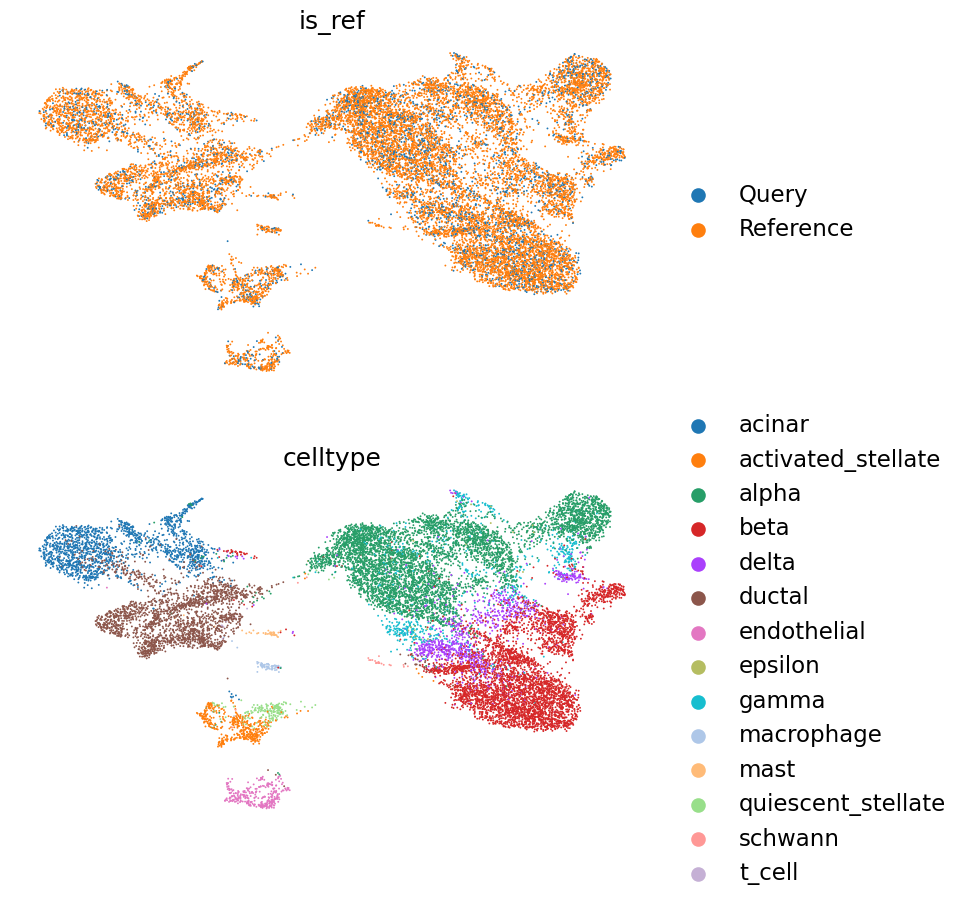

In [7]:
sc.pp.neighbors(adata_embed, use_rep="X_scGPT")
sc.tl.umap(adata_embed)
sc.pl.umap(
    adata_embed, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)


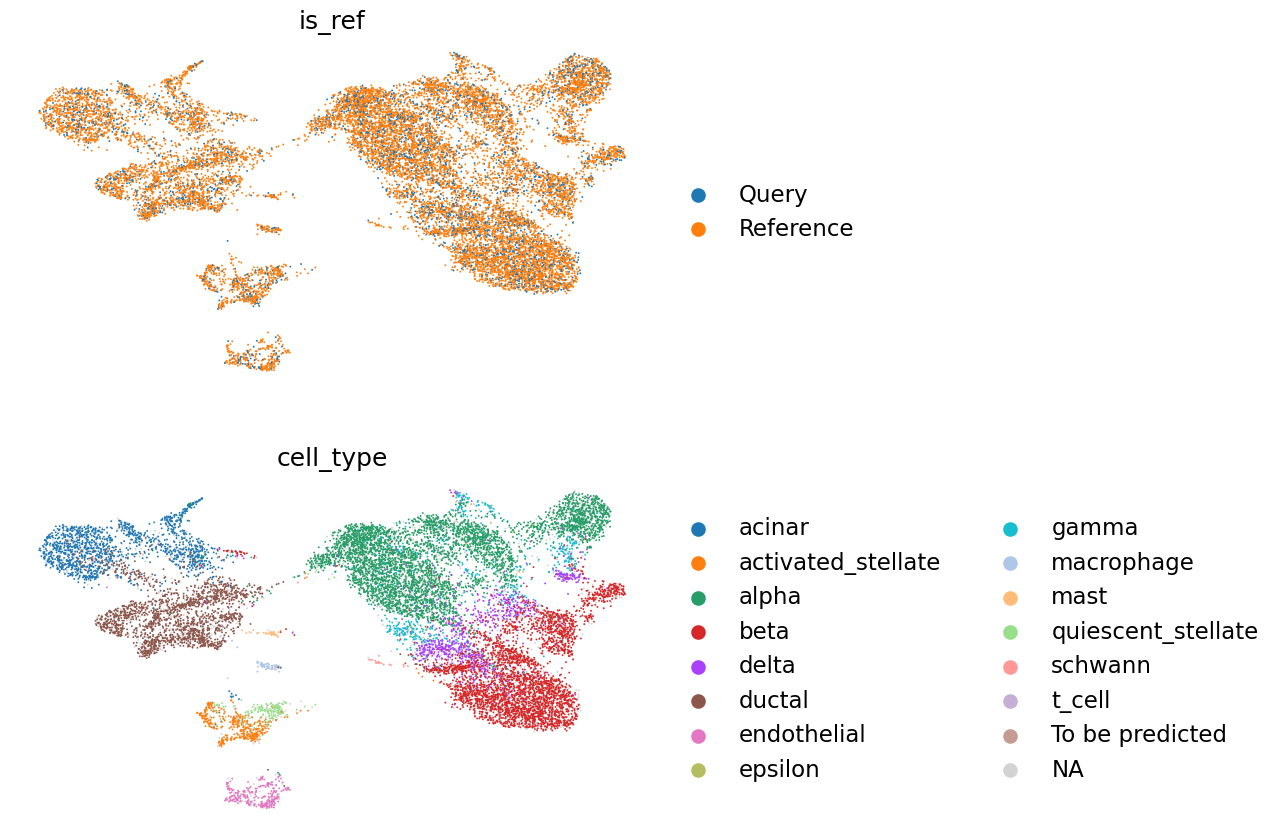

In [8]:
# Temporarily store the query cells' types
temp_types = adata_embed.obs["cell_type"].copy()

# For visualization, set query cells to NA (which will show as grey by default)
adata_embed.obs.loc[adata_embed.obs["is_ref"] == "Query", "cell_type"] = None

# Create the plot
sc.pl.umap(
    adata_embed, 
    color=["is_ref", "cell_type"], 
    wspace=0.4, 
    frameon=False, 
    ncols=1
)

# Restore the original cell types
adata_embed.obs["cell_type"] = temp_types

In [15]:
org_file_path = data_dir / "human_pancreas_norm_complexBatch.h5ad"
adata = sc.read_h5ad(org_file_path)



In [16]:
# 1. Calculate batch correction metrics
batch_metrics = scib.metrics.metrics(
    adata=adata,  # original data
    adata_int=adata_embed,  # integrated/embedded data
    batch_key=batch_key,
    label_key=cell_type_key,
    embed="X_scGPT",  # using scGPT embeddings
    isolated_labels_asw_=True,
    silhouette_=True,
    hvg_score_=True,
    graph_conn_=True,
    pcr_=True,
    isolated_labels_f1_=True,
    nmi_=True,
    ari_=True,
)

# If you don't have the original data, you can use this alternative approach:
# Calculate individual metrics directly

from scib.metrics import isolated_labels_asw, silhouette, hvg_score
from scib.metrics import graph_connectivity, pcr_comparison
from scib.metrics import isolated_labels_f1, nmi, ari

# Calculate metrics individually
metrics_dict = {}

# Batch correction metrics
metrics_dict['pcr'] = pcr_comparison(
    adata_embed,
    batch_key=batch_key,
    label_key=cell_type_key,
    embed='X_scGPT'
)

metrics_dict['graph_conn'] = graph_connectivity(
    adata_embed,
    label_key=cell_type_key
)

# Bio conservation metrics
metrics_dict['isolated_labels_asw'] = isolated_labels_asw(
    adata_embed,
    batch_key=batch_key,
    label_key=cell_type_key,
    embed='X_scGPT'
)

metrics_dict['silhouette'] = silhouette(
    adata_embed,
    batch_key=batch_key,
    label_key=cell_type_key,
    embed='X_scGPT'
)

metrics_dict['nmi'] = nmi(
    adata_embed,
    batch_key=batch_key,
    label_key=cell_type_key
)

metrics_dict['ari'] = ari(
    adata_embed,
    batch_key=batch_key,
    label_key=cell_type_key
)

# Create visualization
metrics_to_plot = {
    'Batch correction': {
        'PCR': metrics_dict['pcr'],
        'Graph connectivity': metrics_dict['graph_conn'],
    },
    'Bio conservation': {
        'Isolated label ASW': metrics_dict['isolated_labels_asw'],
        'Silhouette': metrics_dict['silhouette'],
        'NMI': metrics_dict['nmi'],
        'ARI': metrics_dict['ari'],
    }
}

# Visualization code remains the same
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Integration Evaluation Metrics', fontsize=16)

for idx, (category, metrics) in enumerate(metrics_to_plot.items()):
    ax = axes[idx]
    metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])
    
    sns.barplot(x='Metric', y='Score', data=metrics_df, ax=ax)
    ax.set_title(category)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on top of bars
    for i, v in enumerate(metrics_df['Score']):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Metrics Summary:")
for metric, value in metrics_dict.items():
    print(f"{metric}: {value:.3f}")

Cluster for cluster_0.2 with leiden


c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\clustering.py:96: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  cluster_function(adata, resolution=res, key_added=resolution_key, **kwargs)


Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...


c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scanpy\preprocessing\_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scanpy\preprocessing\_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Isolated labels F1...


c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\isolated_labels.py:311: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Cluster for iso_label_0.2 with leiden
Cluster for iso_label_0.4 with leiden
Cluster for iso_label_0.6 with leiden
Cluster for iso_label_0.8 with leiden
Cluster for iso_label_1.0 with leiden
Cluster for iso_label_1.2 with leiden
Cluster for iso_label_1.4 with leiden
Cluster for iso_label_1.6 with leiden
Cluster for iso_label_1.8 with leiden
Cluster for iso_label_2.0 with leiden
Isolated labels ASW...


c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\isolated_labels.py:311: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).valu

ImportError: cannot import name 'hvg_score' from 'scib.metrics' (c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\scib\metrics\__init__.py)

In [18]:

# Get embeddings for reference cells only
ref_embeddings = adata_embed.obsm["X_scGPT"][adata_embed.obs["is_ref"] == "Reference"]
query_embeddings = adata_embed.obsm["X_scGPT"][adata_embed.obs["is_ref"] == "Query"]

In [17]:
# Those functions are only used when faiss is not installed
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        sims = l2_sim(vector, ref)
        
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

In [20]:
from sklearn.neighbors import NearestNeighbors

# Initialize and fit the nearest neighbors model
nn = NearestNeighbors(n_neighbors=10)  # k=10 nearest neighbors
nn.fit(ref_embeddings)

# Find k nearest neighbors for all test embeddings at once
distances, labels = nn.kneighbors(query_embeddings) 

# Get predictions using the same logic as before
preds = []
for k in range(query_embeddings.shape[0]):
    # Get cell types of nearest neighbors and find most common
    pred = adata_ref.obs[cell_type_key][labels[k]].value_counts()
    preds.append(pred.index[0])



gt = adata_query.obs[cell_type_key].to_numpy()

C:\Users\annel\AppData\Local\Temp\ipykernel_2340\3899343715.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = adata_ref.obs[cell_type_key][labels[k]].value_counts()
C:\Users\annel\AppData\Local\Temp\ipykernel_2340\3899343715.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = adata_ref.obs[cell_type_key][labels[k]].value_counts()
C:\Users\annel\AppData\Local\Temp\ipykernel_2340\3899343715.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

c:\Users\annel\anaconda3\envs\scgpt_py39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


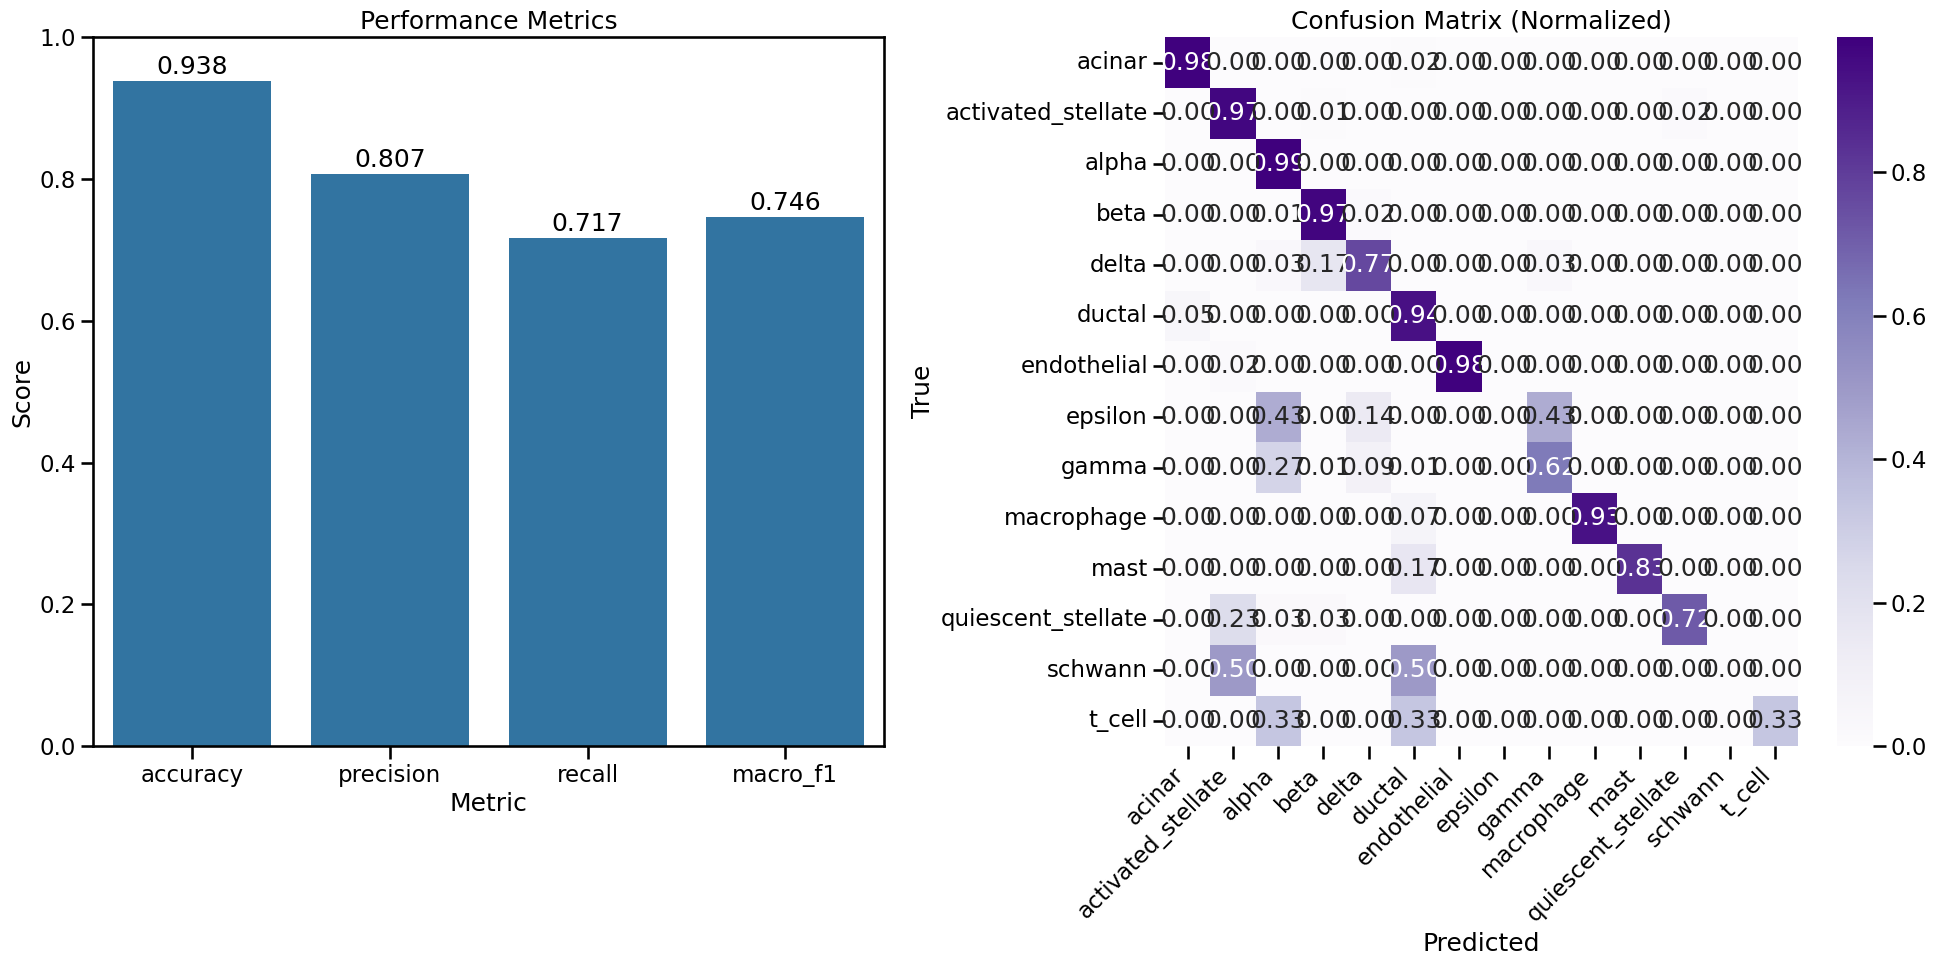


Detailed Performance Metrics:
accuracy: 0.938
precision: 0.807
recall: 0.717
macro_f1: 0.746


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# First, let's calculate and display the performance metrics
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

# Create a figure with two subplots - one for metrics, one for confusion matrix
fig = plt.figure(figsize=(20, 10))

# Left subplot for metrics
ax1 = plt.subplot(121)
metrics_df = pd.DataFrame(list(res_dict.items()), columns=['Metric', 'Score'])
sns.barplot(x='Metric', y='Score', data=metrics_df, ax=ax1)
ax1.set_title('Performance Metrics')
ax1.set_ylim(0, 1)  # Set y-axis from 0 to 1
for i, v in enumerate(metrics_df['Score']):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')  # Add value labels

# Right subplot for confusion matrix
ax2 = plt.subplot(122)
cell_type_list = np.unique(gt)
matrix = confusion_matrix(gt, preds, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

# Create confusion matrix heatmap
df = pd.DataFrame(matrix, 
                 index=cell_type_list[:matrix.shape[0]], 
                 columns=cell_type_list[:matrix.shape[1]])
sns.heatmap(df, 
            cmap='Purples',
            annot=True,
            fmt=".2f",
            cbar=True,
            ax=ax2)

ax2.set_title('Confusion Matrix (Normalized)')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

# Rotate x-axis labels for better readability
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax2.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Performance Metrics:")
for metric, value in res_dict.items():
    print(f"{metric}: {value:.3f}")

In [22]:
# First convert our predictions and ground truth to numpy arrays to ensure consistent handling
gt_array = np.array(gt)
preds_array = np.array(preds)

# Create a summary DataFrame showing predictions vs true labels
summary_df = pd.DataFrame({
    'True_Label': gt_array,
    'Predicted_Label': preds_array
})

# Get basic counts of predictions
print("\nDetailed counts of predictions:")
prediction_counts = pd.crosstab(
    summary_df['True_Label'], 
    summary_df['Predicted_Label'], 
    margins=True
)
print(prediction_counts)

# Now let's analyze each cell type's predictions
print("\nDetailed analysis per cell type:")
for cell_type in np.unique(gt_array):
    # Create boolean mask for this cell type
    mask = gt_array == cell_type
    total = np.sum(mask)
    correct = np.sum((preds_array[mask] == cell_type))
    
    print(f"\nCell type: {cell_type}")
    print(f"Total cells: {total}")
    print(f"Correctly predicted: {correct} ({(correct/total*100):.1f}%)")
    
    if correct < total:
        print("Misclassified as:")
        # Get all predictions for this cell type
        wrong_predictions = preds_array[mask & (preds_array != cell_type)]
        # Count unique values
        unique, counts = np.unique(wrong_predictions, return_counts=True)
        for pred, count in zip(unique, counts):
            print(f"  {pred}: {count} cells ({(count/total*100):.1f}%)")


Detailed counts of predictions:
Predicted_Label     acinar  activated_stellate  alpha  beta  delta  ductal  \
True_Label                                                                   
acinar                 318                   0      1     0      0       5   
activated_stellate       0                  89      0     1      0       0   
alpha                    0                   1   1093     4      5       1   
beta                     0                   0      6   786     17       0   
delta                    0                   0      7    39    173       0   
ductal                  20                   1      1     2      1     388   
endothelial              0                   1      0     0      0       0   
epsilon                  0                   0      3     0      1       0   
gamma                    0                   0     37     1     12       1   
macrophage               0                   0      0     0      0       1   
mast                     0     

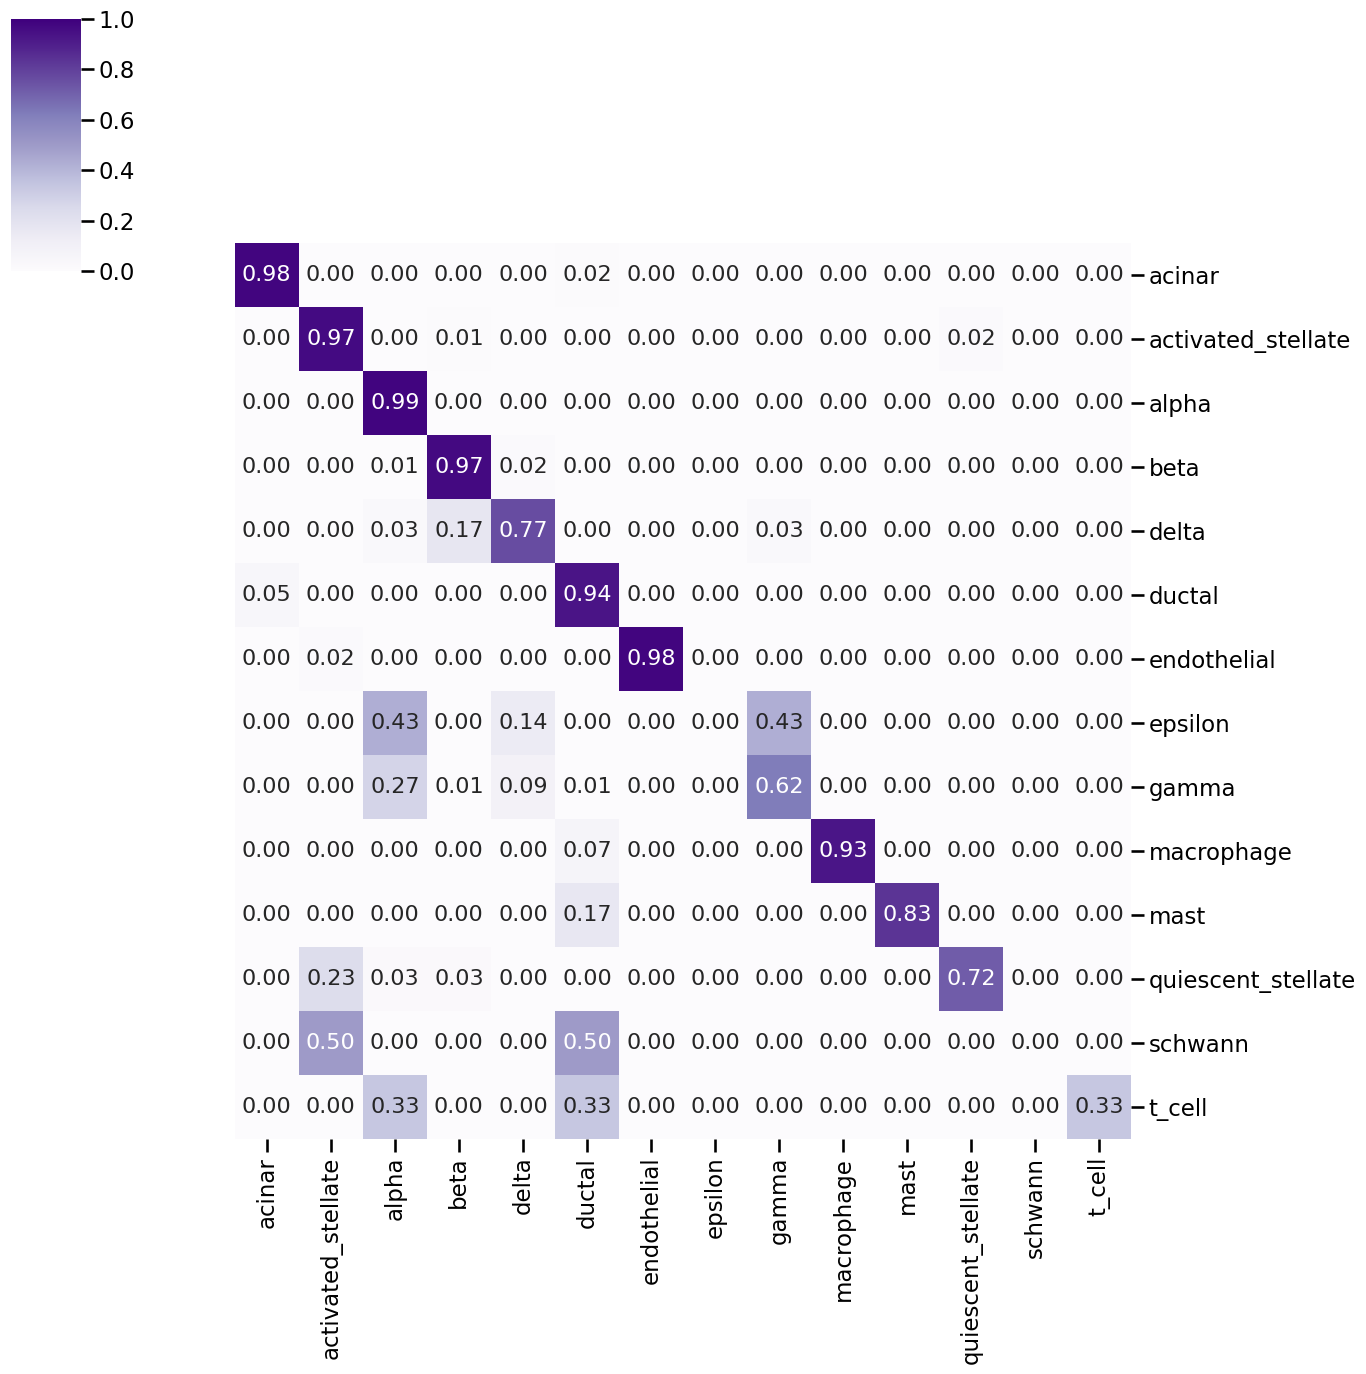

In [23]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,
                    fmt=".2f", 
                    annot_kws={'size': 16}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(14, 14))